# Feature Analysis

A notebook to find example pairs of ranked specs where both specs have the same set of features. This is not good as w cannot learn a difference.

In [30]:
from draco.learn.data_util import get_labeled_data, _get_pos_neg_data, get_nested_index
import json
from vega3 import VegaLite
from pprint import pprint
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, SpectralClustering
import seaborn as sns
import random
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
raw_data, _ = get_labeled_data()

In [3]:
data = _get_pos_neg_data()  # calling internal function

In [4]:
X = data.negative - data.positive

In [5]:
# save features for facets: https://pair-code.github.io/facets/
X.to_csv('../__tmp__/features.csv')

##  Find pairs that are impossible to distinguish because the feature vectors are the same

In [6]:
sums = X.abs().sum(axis=1)

In [7]:
bad = data[sums == 0]
print(len(bad))

0


In [8]:
bad.index

Index([], dtype='object')

In [9]:
# bad.positive.iloc[0]

In [10]:
# bad.negative.iloc[0]

In [11]:
# e = raw_data[bad.index[0]]
# print(e.data.to_asp())
# pprint(e.negative)
# pprint(e.positive)

## Cluster Training Data

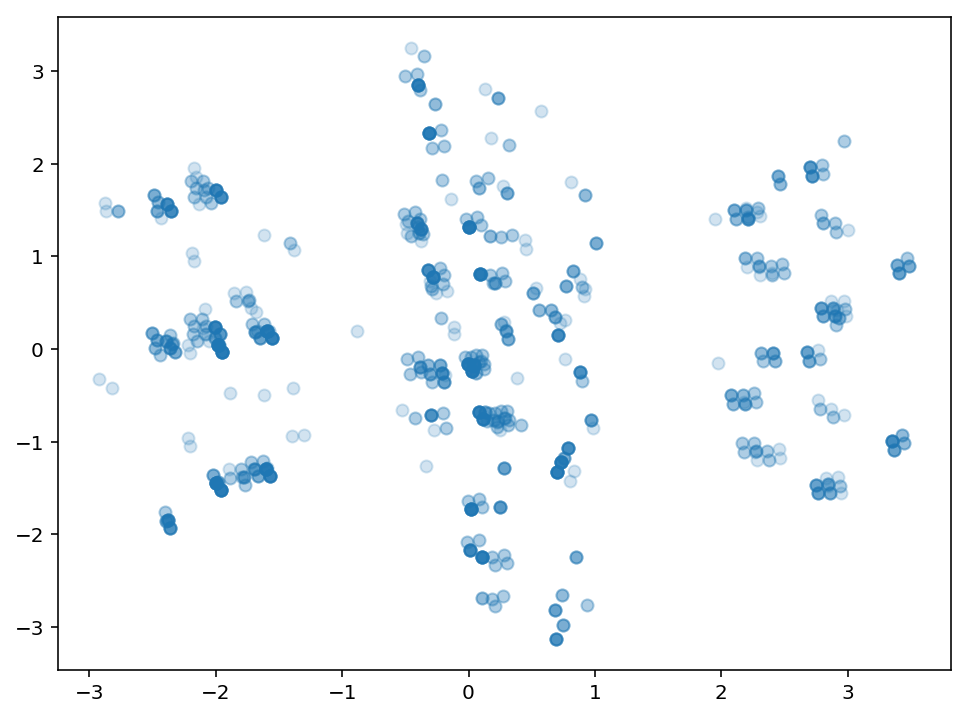

In [12]:
pca = PCA(n_components=2)
fit = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(fit[:,0], fit[:,1], alpha=0.2)

In [13]:
model = KMeans(n_clusters=7)
# model = SpectralClustering(n_clusters=7)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
df = pd.DataFrame(fit[:,:2], columns=['x0', 'x1'])
df.index = data.index
df['cluster'] = model.labels_
df['source'] = data.source
df['task'] = data.task

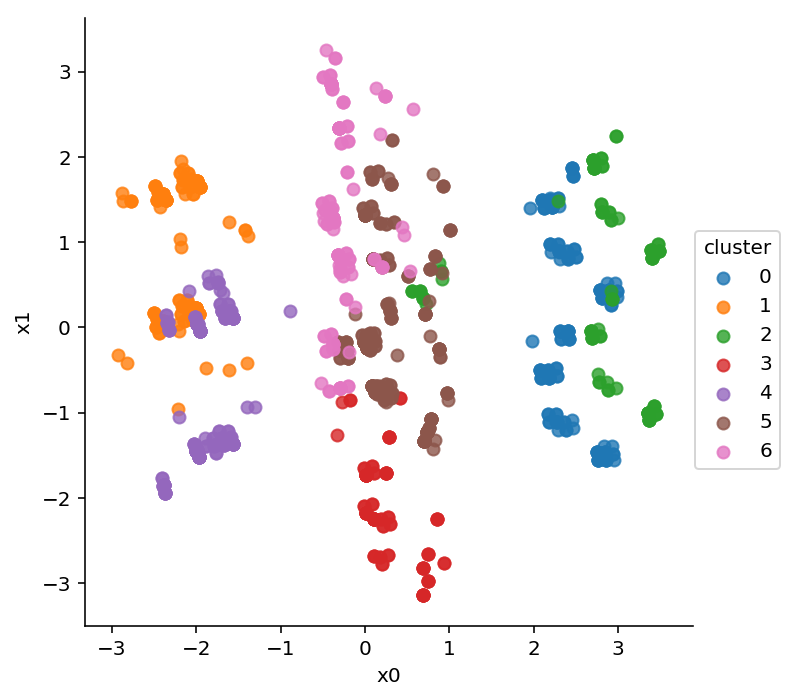

In [15]:
sns.lmplot(x='x0', y='x1', data=df, hue='cluster', fit_reg=False)

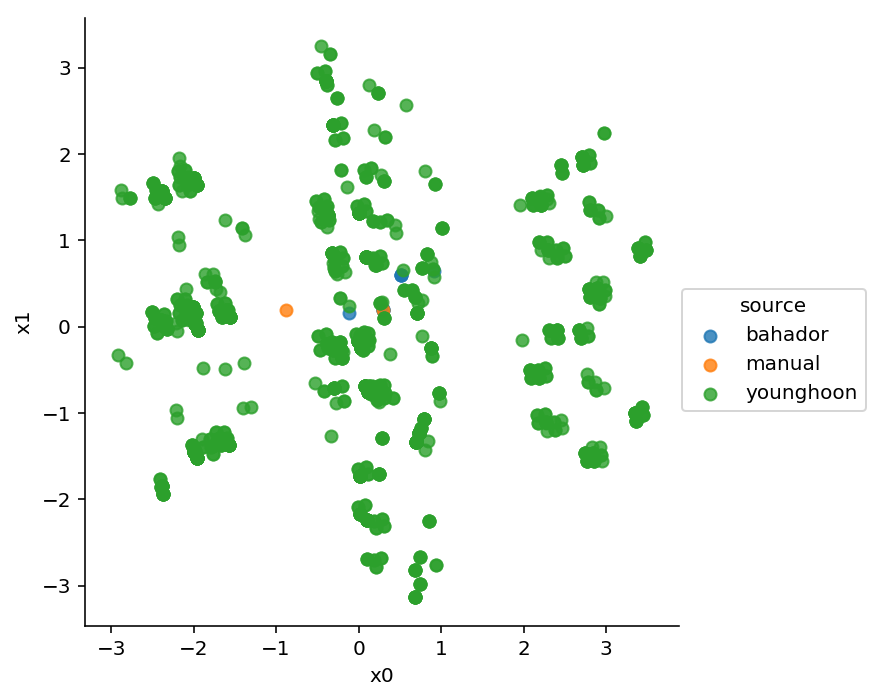

In [16]:
sns.lmplot(x='x0', y='x1', data=df, hue='source', fit_reg=False)

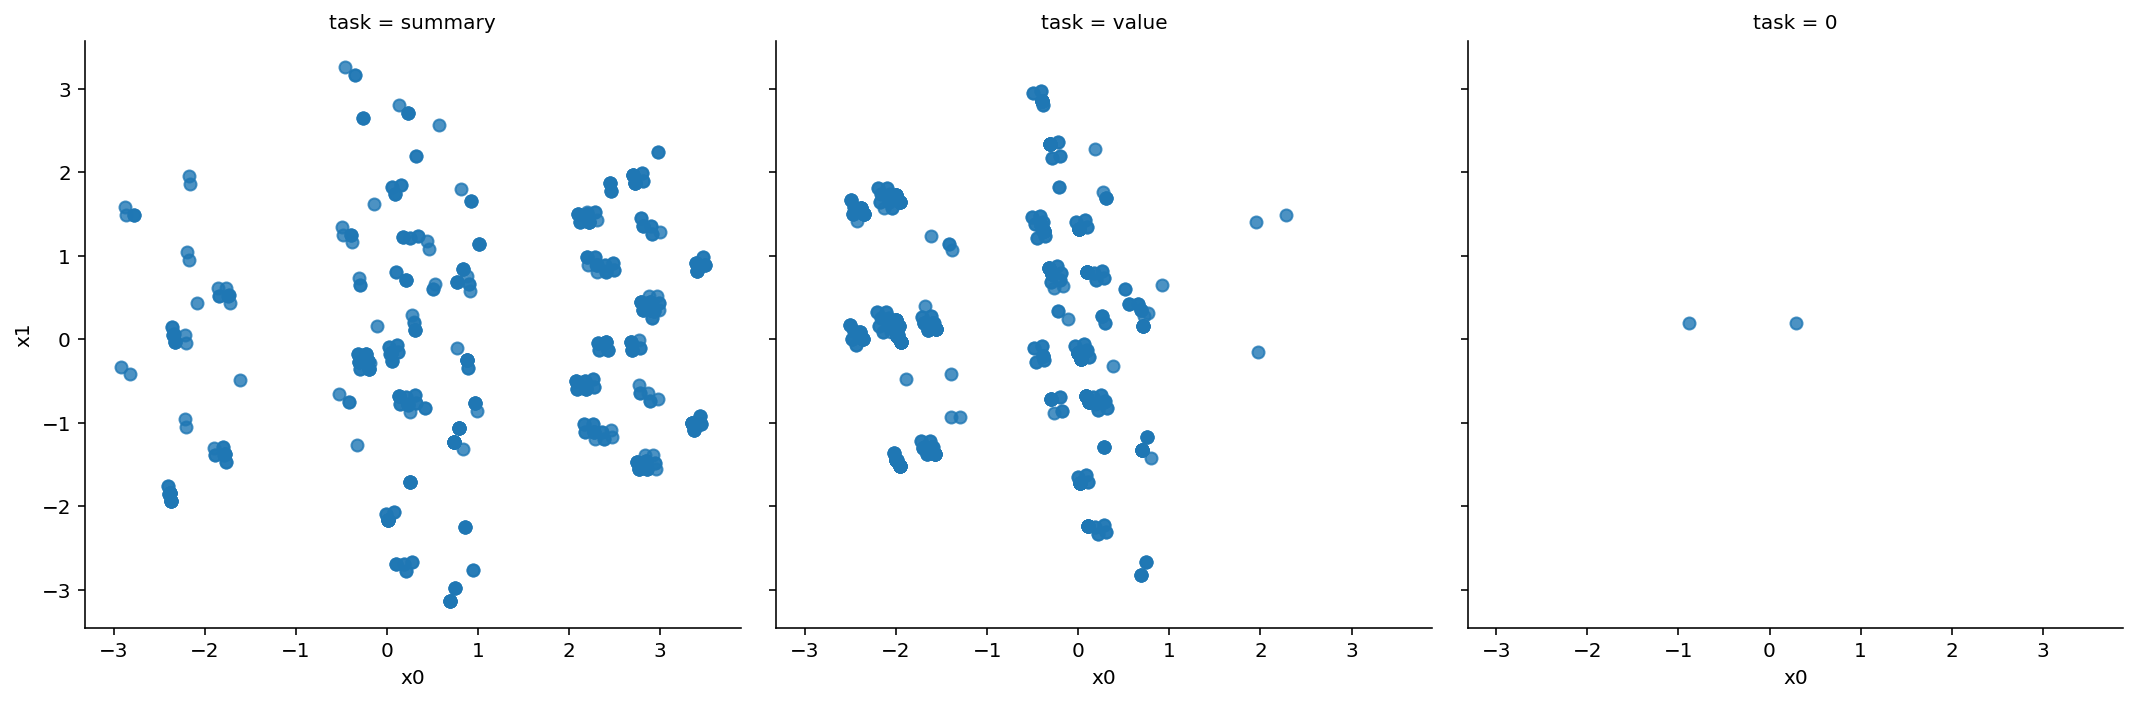

In [17]:
sns.lmplot(x='x0', y='x1', data=df, col='task', fit_reg=False)

In [18]:
i = df[df.cluster == 5].index[1]
pair = raw_data[i]

In [19]:
pair.data.fill_with_random_content()

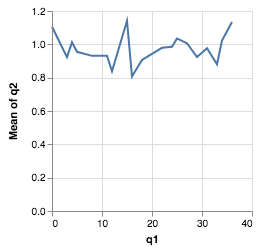

In [20]:
spec = pair.negative
spec['data'] = {
    'values': pair.data.content
}

VegaLite(spec)

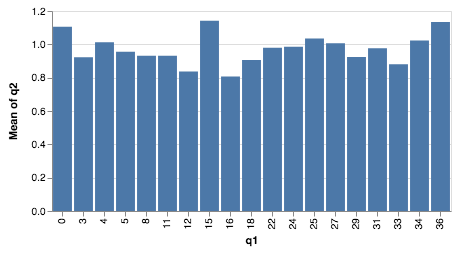

In [21]:
spec = pair.positive
spec['data'] = {
    'values': pair.data.content
}

VegaLite(spec)

### Which features are meaningful for the clustering

In [22]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X, model.labels_)
tree.score(X, model.labels_)

1.0

In [23]:
# with the score being 1, we can perfectly explain all the clusters with just these features
X.columns[tree.feature_importances_ > 0]

Index(['c_d_point', 'color_entropy_high', 'continuous_color',
       'continuous_size', 'high_cardinality_size', 'interesting_size',
       'nominal_x', 'nominal_y', 'size_entropy_high', 'summary_continuous_x',
       'summary_continuous_y', 'x_row', 'y_row'],
      dtype='object', name='feature')

## Leverage Scores

In [24]:
u, s, vh = np.linalg.svd(X, full_matrices=False)
lev_scores = np.sum(u*u, axis=1)

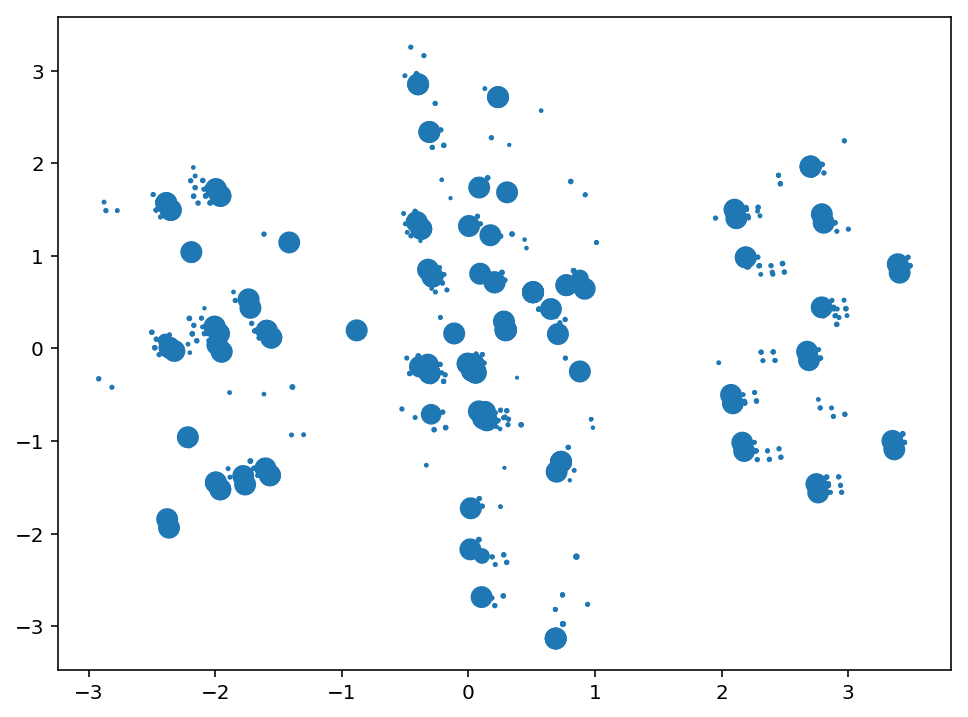

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(df.x0, df.x1, s=100*lev_scores)

In [26]:
lev_scores.argmax()

3

In [27]:
label = X.iloc[lev_scores.argmax()]
raw_data[label.name]

PosNeg(pair_id='saket2018-3', data=<draco.spec.Data object at 0x11e400400>, task='summary', source='saket2018', negative={'mark': 'line', 'encoding': {'x': {'field': 'q1', 'type': 'quantitative'}, 'y': {'field': 'q2', 'type': 'quantitative', 'aggregate': 'mean', 'scale': {'zero': True}}}}, positive={'mark': 'point', 'encoding': {'x': {'field': 'q1', 'type': 'quantitative'}, 'y': {'field': 'q2', 'type': 'quantitative', 'aggregate': 'mean', 'scale': {'zero': True}}}})

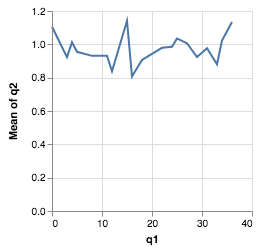

In [28]:
if pair.data.content is None:
    pair.data.fill_with_random_content()

spec = pair.negative
spec['data'] = {
    'values': pair.data.content
}

VegaLite(spec)

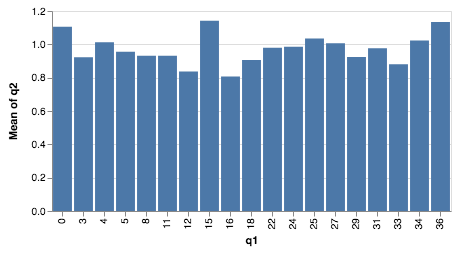

In [29]:
spec = pair.positive
spec['data'] = {
    'values': pair.data.content
}

VegaLite(spec)